In [ ]:
1! pip install tldextract
! pip install colorama
! pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tldextract
from sklearn import tree
from colorama import Fore
from urllib.parse import urlparse
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from tld import get_tld,is_tld


LOAD DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/URL /URLs/phising_urls_detection

/content/drive/MyDrive/URL /URLs/phising_urls_detection


In [ ]:
data=pd.read_csv('./data/URL.csv')
data.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
count=data.type.value_counts()
count

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

Text(0, 0.5, 'Count')

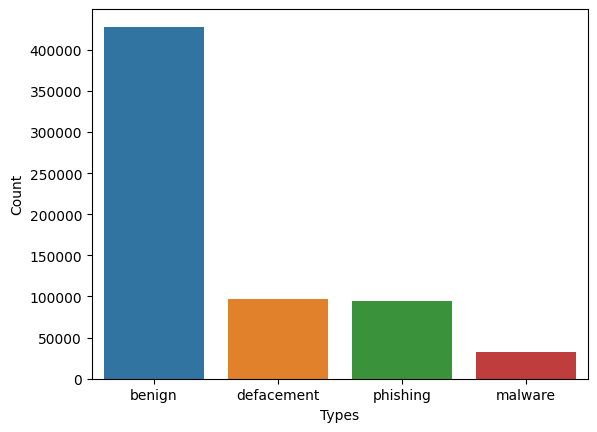

In [ ]:
sns.barplot(x=count.index,y=count)
plt.xlabel("Types")
plt.ylabel("Count")

In [ ]:
data['url']=data['url'].replace('www.','',regex=True)
data.head(20)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [ ]:
data['Category']=data['type']
data['Category'].replace({"benign":0,"defacement":1,"phishing":2,"malware":3},inplace=True)
data.head(20)

,url,type,Category
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0
8,http://pashminaonline.com/pure-pashminas,defacement,1
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0


In [ ]:
data['url_len'] = data['url'].apply(lambda x:len(x))
data.head(20)

,url,type,Category,url_len
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,118
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0,46
8,http://pashminaonline.com/pure-pashminas,defacement,1,40
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0,45


In [ ]:
special_characters=['@','?','-','=','.','#','%','+','$','!','*',',','//']
def haveChar(i,char):
    if i.count(char):
        return 1
    return 0

for char in special_characters:
    data[char]=data['url'].apply(lambda i:haveChar(i,char))
data.head(20)

,url,type,Category,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,0,0,1,0,1,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,1,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,1,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0,1,1,1,1,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0,1,1,1,1,0,0,0,0,0,0,0,1
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,118,0,0,1,0,1,0,0,0,0,0,0,0,1
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45,0,0,1,0,1,0,0,0,0,0,0,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0,46,0,1,1,1,1,0,0,0,0,0,0,0,0
8,http://pashminaonline.com/pure-pashminas,defacement,1,40,0,0,1,0,1,0,0,0,0,0,0,0,1
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0,45,0,0,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 0
    else:
        return 1
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))
data.head(20)


,url,type,Category,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url
0,br-icloud.com.br,phishing,2,16,0,0,1,0,1,0,0,0,0,0,0,0,0,1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0,1,1,1,1,0,0,0,0,0,0,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0,1,1,1,1,0,0,0,0,0,0,0,1,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,118,0,0,1,0,1,0,0,0,0,0,0,0,1,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45,0,0,1,0,1,0,0,0,0,0,0,0,0,1
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0,46,0,1,1,1,1,0,0,0,0,0,0,0,0,1
8,http://pashminaonline.com/pure-pashminas,defacement,1,40,0,0,1,0,1,0,0,0,0,0,0,0,1,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0,45,0,0,1,0,1,0,0,0,0,0,0,0,0,1


<Axes: xlabel='abnormal_url', ylabel='count'>

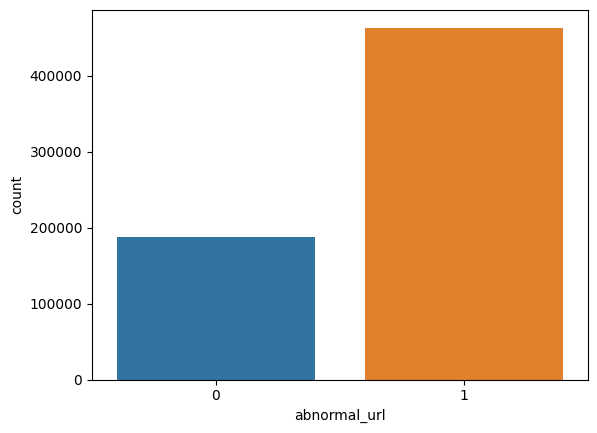

In [ ]:
sns.countplot(x='abnormal_url', data=data)

In [ ]:
def isHTTPS(url):
    scheme= urlparse(url).scheme

    str_scheme=str(scheme)
    if str_scheme=='https':
        return 1
    return 0
data['https']=data['url'].apply(lambda i:isHTTPS(i))
data.head(20)

,url,type,Category,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https
0,br-icloud.com.br,phishing,2,16,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,118,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0,46,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0
8,http://pashminaonline.com/pure-pashminas,defacement,1,40,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0,45,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0


In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits=digits+1
    return digits
data['digits']=data['url'].apply(lambda i:digit_count(i))
data.head(20)

,url,type,Category,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits
0,br-icloud.com.br,phishing,2,16,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,7
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,22
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,118,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,4
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0,46,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0
8,http://pashminaonline.com/pure-pashminas,defacement,1,40,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0,45,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,5


In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
data['letters']= data['url'].apply(lambda i: letter_count(i))
data.head(20)

,url,type,Category,url_len,@,?,-,=,.,#,...,+,$,!,*,",",//,abnormal_url,https,digits,letters
0,br-icloud.com.br,phishing,2,16,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,25
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0,1,1,1,1,0,...,0,0,0,0,0,1,0,0,7,60
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0,1,1,1,1,0,...,0,0,0,0,0,1,0,0,22,199
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,118,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,1,93
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,4,31
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0,46,0,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,40
8,http://pashminaonline.com/pure-pashminas,defacement,1,40,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,34
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0,45,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,5,33


In [ ]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
data['shortining_service']=data['url'].apply(lambda i:Shortining_Service(i))
data.head(20)

,url,type,Category,url_len,@,?,-,=,.,#,...,$,!,*,",",//,abnormal_url,https,digits,letters,shortining_service
0,br-icloud.com.br,phishing,2,16,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,25,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0,1,1,1,1,0,...,0,0,0,0,1,0,0,7,60,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0,1,1,1,1,0,...,0,0,0,0,1,0,0,22,199,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,118,0,0,1,0,1,0,...,0,0,0,0,1,0,0,1,93,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45,0,0,1,0,1,0,...,0,0,0,0,0,1,0,4,31,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0,46,0,1,1,1,1,0,...,0,0,0,0,0,1,0,0,40,1
8,http://pashminaonline.com/pure-pashminas,defacement,1,40,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,34,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0,45,0,0,1,0,1,0,...,0,0,0,0,0,1,0,5,33,0


In [ ]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))
data.head(20)



,url,type,Category,url_len,@,?,-,=,.,#,...,!,*,",",//,abnormal_url,https,digits,letters,shortining_service,having_ip_address
0,br-icloud.com.br,phishing,2,16,0,0,1,0,1,0,...,0,0,0,0,1,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,1,0,...,0,0,0,0,1,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,1,0,...,0,0,0,0,1,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0,1,1,1,1,0,...,0,0,0,1,0,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0,1,1,1,1,0,...,0,0,0,1,0,0,22,199,0,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,118,0,0,1,0,1,0,...,0,0,0,1,0,0,1,93,0,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45,0,0,1,0,1,0,...,0,0,0,0,1,0,4,31,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0,46,0,1,1,1,1,0,...,0,0,0,0,1,0,0,40,1,0
8,http://pashminaonline.com/pure-pashminas,defacement,1,40,0,0,1,0,1,0,...,0,0,0,1,0,0,0,34,0,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0,45,0,0,1,0,1,0,...,0,0,0,0,1,0,5,33,0,0


<ipython-input-23-6cc696ead30e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), linewidths=.5)


<Axes: >

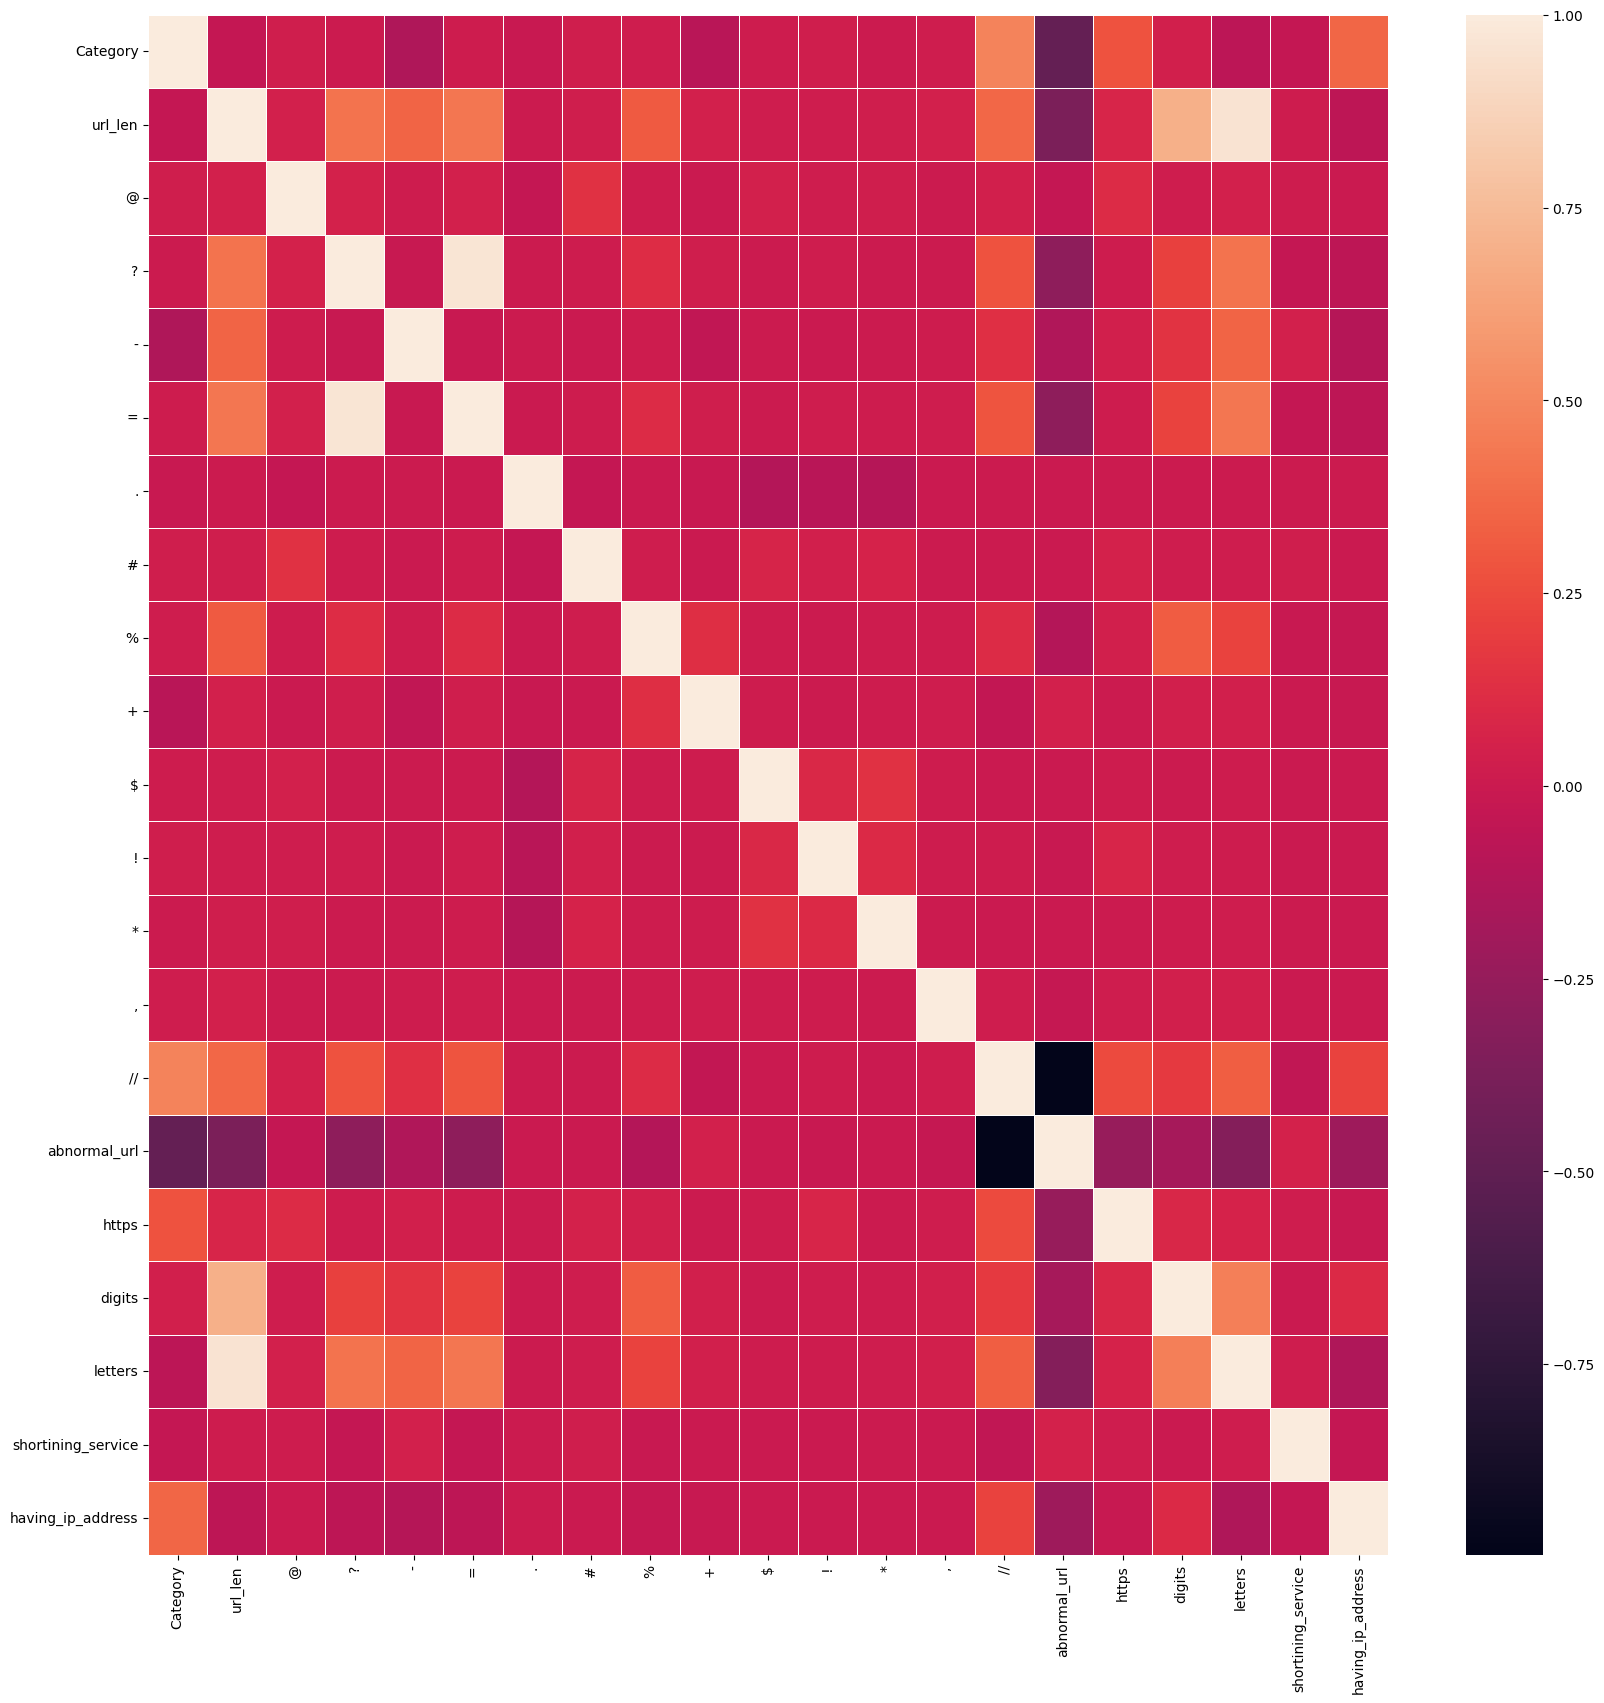

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), linewidths=.5)

In [ ]:
X = data.drop(['url','type','Category'],axis=1)
y=data['Category']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=2)


In [ ]:
models = [SVC,DecisionTreeClassifier,RandomForestClassifier,GaussianNB,LogisticRegression]

accuracy_test=[]
accuracy_train=[]
for m in models:
    print('--------------------------------------------------------')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    print(type(y_train))
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    # print('Training Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc2*100))

    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()
    print('\033[31m###################- End -###################\033[0m')

--------------------------------------------------------
######-Model => <class 'sklearn.svm._classes.SVC'> 
<class 'pandas.core.series.Series'>


In [ ]:
output = pd.DataFrame({"Model":['Decision Tree Classifier',
                                'Random Forest Classifier',
                                'Gaussian NB'],
                      "Accuracy":accuracy_test})
output

,Model,Accuracy
0,Decision Tree Classifier,0.887499
1,Random Forest Classifier,0.891123
2,Gaussian NB,0.789625


In [ ]:
X_test

,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits,letters,shortining_service,having_ip_address
238731,96,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,2,76,0,0
309364,84,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,13,59,0,0
170638,83,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,31,30,0,0
246063,14,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,12,0,0
466287,39,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,5,27,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348509,78,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,4,58,0,0
500295,28,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,25,0,0
53597,82,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,4,63,0,0
26012,26,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,22,0,0


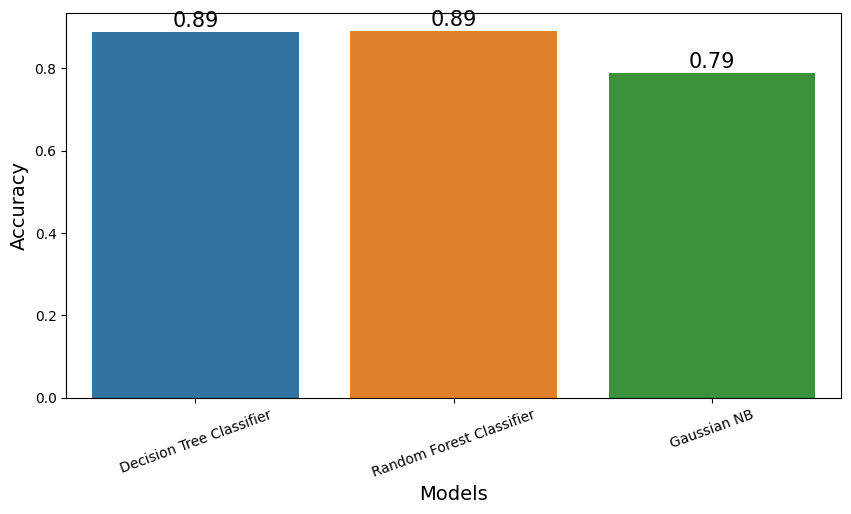

In [ ]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

In [ ]:
def URL_Converter(urls):
    data= pd.DataFrame()
    data['url'] = pd.Series(urls)


    data['url_len'] = data['url'].apply(lambda x: len(str(x)))
    feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
    for a in feature:
        data[a] = data['url'].apply(lambda i: haveChar(i,a))
    data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))
    data['https'] = data['url'].apply(lambda i: isHTTPS(i))
    data['digits']= data['url'].apply(lambda i: digit_count(i))
    data['letters']= data['url'].apply(lambda i: letter_count(i))
    data['shortining_service'] = data['url'].apply(lambda x: Shortining_Service(x))
    data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))
    print(data.columns)
    X = data.drop(['url'],axis=1)

    return X

In [ ]:
urls= ['diaryofagameaddict.com',
'espdesign.com.au',
'iamagameaddict.com',
'kalantzis.net',
'slightlyoffcenter.net',
'toddscarwash.com',
'tubemoviez.com',
'ipl.hk',
'crackspider.us/toolbar/install.php?pack=exe',
'pos-kupang.com/',
'rupor.info',
'svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt',
'officeon.ch.ma/office.js?google_ad_format=728x90_as',
'sn-gzzx.com',
'sunlux.net/company/about.html',
'outporn.com',
'timothycopus.aimoo.com',
'xindalawyer.com',
'freeserials.spb.ru/key/68703.htm',
'deletespyware-adware.com',
'orbowlada.strefa.pl/text396.htm',
'ruiyangcn.com',
'zkic.com',
'adserving.favorit-network.com/eas?camp=19320;cre=mu&grpid=1738&tag_id=618&nums=FGApbjFAAA',
'cracks.vg/d1.php',
'juicypussyclips.com',
'nuptialimages.com',
'andysgame.com',
'bezproudoff.cz',
'ceskarepublika.net',
'hotspot.cz',
'gmcjjh.org/DHL',
'nerez-schodiste-zabradli.com',
'nordiccountry.cz',
'nowina.info',
'obada-konstruktiwa.org',
'otylkaaotesanek.cz',
'pb-webdesign.net',
'pension-helene.cz',
'podzemi.myotis.info',
'smrcek.com',
'spekband.com',
'm2132.ehgaugysd.net/zyso.cgi?18',
'webcom-software.ws/links/?153646e8b0a88',
'worldgymperu.com',
'zgsysz.com',
'oknarai.ru',
'realinnovation.com/css/menu.js']

In [ ]:
test_data= URL_Converter(urls)

Index(['url', 'url_len', '@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*',
       ',', '//', 'abnormal_url', 'https', 'digits', 'letters',
       'shortining_service', 'having_ip_address'],
      dtype='object')


In [ ]:
models

[sklearn.tree._classes.DecisionTreeClassifier,
 sklearn.ensemble._forest.RandomForestClassifier,
 sklearn.naive_bayes.GaussianNB]

In [ ]:
for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(test_data)
    print(pred)

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
[2 0 2 2 2 2 2 2 0 0 2 0 0 2 0 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 2 0 0 2 2 2 2
 2 2 0 2 2 0 0 2 2 2 0]
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
[2 0 2 2 2 2 2 2 0 0 2 0 0 0 0 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 2 0 0 2 2 2 2
 2 2 0 2 2 0 0 2 2 2 0]
#############################################
######-Model => <class 'sklearn.naive_bayes.GaussianNB'> 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
output = pd.DataFrame({"Model":['Decision Tree Classifier',
                                'Random Forest Classifier',
                                'Gaussian NB'],
                      "Accuracy":accuracy_test})
output

,Model,Accuracy
0,Decision Tree Classifier,0.887499
1,Random Forest Classifier,0.891123
2,Gaussian NB,0.789625
